# CNN Text Classification (Keras)

This notebook mirrors the XGBoost workflow but trains a **Convolutional Neural Network (CNN)** for a **multi-class text classification** task.

**Highlights**
- Input data: CSV with two columns: `text` and `target` (target has 432 classes).
- Tokenization + padding → `Embedding` → `Conv1D` blocks → `GlobalMaxPooling` → `Dense` → softmax.
- Class-imbalance aware (`class_weight` support).
- EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint.
- Evaluation: Accuracy, Macro-F1, Balanced Accuracy, Top-5 Accuracy, classification report.
- Plots: class distribution, training curves; optional large confusion matrix.

> **Note:** The notebook does not download external embeddings (internet is disabled at runtime). The `Embedding` layer is trained from scratch.


In [7]:
# !pip install -q tensorflow scikit-learn pandas numpy matplotlib
import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score, accuracy_score, confusion_matrix, top_k_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))


2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration

In [9]:
from datetime import datetime

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

@dataclass
class Config:
    csv_path: str = '/content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/cnn/data_final_min30.csv'  # <-- set this
    text_col: str = 'text'
    target_col: str = 'target'
    num_classes: int = 432
    # Tokenization
    vocab_size: int = 60000    # cap vocabulary; adjust if needed
    oov_token: str = '<OOV>'
    max_len: int = 256         # sequence length after padding
    # Model
    embedding_dim: int = 128
    conv_filters: Tuple[int, ...] = (256, 256)
    kernel_sizes: Tuple[int, ...] = (3, 5)
    dense_units: int = 256
    dropout_rate: float = 0.4
    # Training
    batch_size: int = 128
    epochs: int = 100
    val_size: float = 0.10
    test_size: float = 0.10
    use_class_weight: bool = True
    # Files
    out_dir: str = 'artifacts_cnn'

cfg = Config()
os.makedirs(cfg.out_dir, exist_ok=True)
cfg_dict = cfg.__dict__
with open(os.path.join(cfg.out_dir, 'config.json'), 'w') as f:
    json.dump(cfg_dict, f, indent=2)
cfg_dict


{'csv_path': '/content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/cnn/data_final_min30.csv',
 'text_col': 'text',
 'target_col': 'target',
 'num_classes': 432,
 'vocab_size': 60000,
 'oov_token': '<OOV>',
 'max_len': 256,
 'embedding_dim': 128,
 'conv_filters': (256, 256),
 'kernel_sizes': (3, 5),
 'dense_units': 256,
 'dropout_rate': 0.4,
 'batch_size': 128,
 'epochs': 100,
 'val_size': 0.1,
 'test_size': 0.1,
 'use_class_weight': True,
 'out_dir': 'artifacts_cnn'}

## Load data

In [10]:
df = pd.read_csv(cfg.csv_path)
assert cfg.text_col in df.columns and cfg.target_col in df.columns, 'CSV must have columns: text, target'
print(df.shape)
df.head()


(145415, 2)


,text,target
0,"In December 2015, when fishermen took their bo...",3-d graphics
1,HYDERABAD: Students of the International Insti...,3-d graphics
2,"<div class=""section1""><div class=""Normal"">Fran...",3-d graphics
3,"VISAKHAPATNAM: Officially, they may be called ...",adoption and fostering
4,NAGPUR: Keeping pace with the ecofriendly mov...,adult education


### Basic EDA (optional)

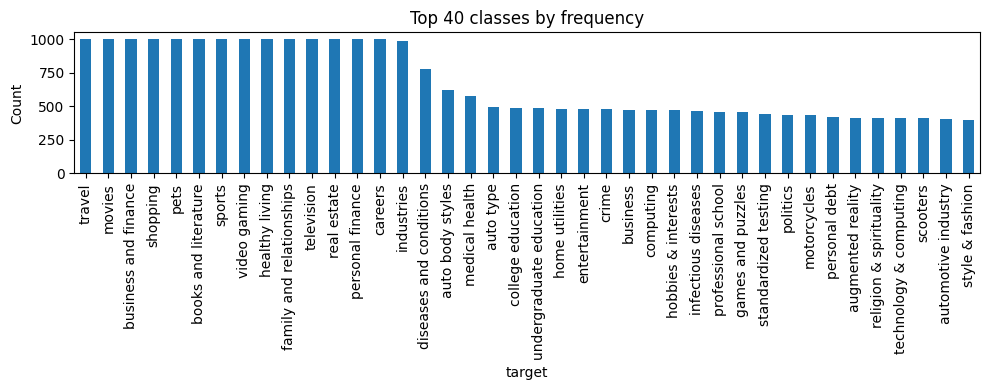

,count
count,432.000000
mean,336.608796
std,137.237046
min,38.000000
25%,289.750000
50%,303.000000
75%,328.000000
max,1000.000000


In [11]:
class_counts = df[cfg.target_col].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,4))
top_n = 40
class_counts.iloc[:top_n].plot(kind='bar')
plt.title(f'Top {top_n} classes by frequency')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
class_counts.describe()


## Train/Val/Test split

We use an 80/10/10 split. If `EarlyStopping` is enabled, the validation set is used for early stopping and LR scheduling.

In [12]:
X = df[cfg.text_col].astype(str).values
y_raw = df[cfg.target_col].astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print('Detected classes:', num_classes)
assert num_classes == cfg.num_classes, 'Config num_classes does not match detected classes.'

# initial train/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=cfg.val_size + cfg.test_size, random_state=SEED, stratify=y
)
rel_test = cfg.test_size / (cfg.val_size + cfg.test_size)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=rel_test, random_state=SEED, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


Detected classes: 432


(116332, 14541, 14542)

In [13]:
import tensorflow as tf

print("GPUs detected:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0


## Tokenize & Pad

In [14]:
tokenizer = Tokenizer(num_words=cfg.vocab_size, oov_token=cfg.oov_token)
tokenizer.fit_on_texts(X_train)

def to_seq(texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=cfg.max_len, padding='post', truncating='post')

X_train_seq = to_seq(X_train)
X_val_seq = to_seq(X_val)
X_test_seq = to_seq(X_test)

np.save(os.path.join(cfg.out_dir, 'label_encoder_classes.npy'), le.classes_)
with open(os.path.join(cfg.out_dir, 'tokenizer.json'), 'w') as f:
    f.write(tokenizer.to_json())

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape


((116332, 256), (14541, 256), (14542, 256))

## Build CNN Model

In [15]:
def build_cnn(cfg, num_classes: int) -> tf.keras.Model:
    model = Sequential()
    model.add(Embedding(input_dim=cfg.vocab_size, output_dim=cfg.embedding_dim, input_length=cfg.max_len))
    for filters, k in zip(cfg.conv_filters, cfg.kernel_sizes):
        model.add(Conv1D(filters=filters, kernel_size=k, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(cfg.dropout_rate))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(cfg.dense_units, activation='relu'))
    model.add(Dropout(cfg.dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5')]
    )
    return model

model = build_cnn(cfg, num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Class Weights (optional)
Compute balanced class weights to help with class imbalance.

In [16]:
class_weight = None
if cfg.use_class_weight:
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
    len(class_weight), list(class_weight.items())[:5]


## Train

In [17]:
num_classes

432

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint(os.path.join(cfg.out_dir, 'best_cnn.keras'), monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    batch_size=cfg.batch_size,
    epochs=cfg.epochs,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

pd.DataFrame(history.history).to_csv(os.path.join(cfg.out_dir, 'history.csv'), index=False)


Epoch 1/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.0051 - loss: 6.2787 - top5: 0.0248 - val_accuracy: 0.0047 - val_loss: 5.8300 - val_top5: 0.0205 - learning_rate: 0.0010
Epoch 2/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0055 - loss: 5.8970 - top5: 0.0307 - val_accuracy: 0.0199 - val_loss: 5.5753 - val_top5: 0.0880 - learning_rate: 0.0010
Epoch 3/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0118 - loss: 5.6693 - top5: 0.0541 - val_accuracy: 0.0382 - val_loss: 5.2566 - val_top5: 0.1573 - learning_rate: 0.0010
Epoch 4/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0193 - loss: 5.3967 - top5: 0.0810 - val_accuracy: 0.0596 - val_loss: 4.9502 - val_top5: 0.2001 - learning_rate: 0.0010
Epoch 5/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0290 - loss: 5.0733 - top5: 0.1123 - val_accuracy: 0.0841 - val_loss: 4.6220 - val_top5: 0.2761 - learning_rate: 0.0010
Epoch 6/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy

In [19]:
# Stronger multi-branch Text-CNN (Kim-style) with label smoothing and top-5 metric
def build_text_cnn_v2(cfg, num_classes: int) -> tf.keras.Model:
    inp = tf.keras.Input(shape=(cfg.max_len,), dtype='int32')
    x = Embedding(cfg.vocab_size, cfg.embedding_dim, input_length=cfg.max_len)(inp)
    x = tf.keras.layers.SpatialDropout1D(0.2)(x)

    branches = []
    for k in (3, 4, 5, 7):
        b = Conv1D(256, k, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        b = BatchNormalization()(b)
        b = tf.keras.layers.SeparableConv1D(256, k, padding='same', activation='relu')(b)
        b = GlobalMaxPooling1D()(b)
        branches.append(b)

    h = tf.keras.layers.Concatenate()(branches)
    h = Dropout(0.25)(h)
    h = Dense(512, activation='relu', kernel_initializer='he_normal')(h)
    h = BatchNormalization()(h)
    h = Dropout(0.5)(h)
    out = Dense(num_classes, activation='softmax')(h)

    model = tf.keras.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=2e-3, clipnorm=1.0)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5')])
    return model

# Rebuild and retrain (overwrites `model` and `history`)
model = build_text_cnn_v2(cfg, num_classes)
model.summary()

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    batch_size=cfg.batch_size,
    epochs=cfg.epochs,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

pd.DataFrame(history.history).to_csv(os.path.join(cfg.out_dir, 'history_v2.csv'), index=False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 256, 128)  │  7,680,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 256, 128)  │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 256)  │     98,560 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 256, 256)  │    131,328 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 256)  │    164,096 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 256)  │    229,632 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 256, 256)  │     66,560 │ batch_normalizat… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 256, 256)  │     66,816 │ batch_normalizat… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_2  │ (None, 256, 256)  │     67,072 │ batch_normalizat… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 256, 256)  │     67,584 │ batch_normalizat… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ separable_conv1d… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ separable_conv1d… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ separable_conv1d… │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 9,324,208 (35.57 MB)

 Trainable params: 9,321,136 (35.56 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 134s 105ms/step - accuracy: 0.0880 - loss: 5.0686 - top5: 0.2058 - val_accuracy: 0.5841 - val_loss: 1.6687 - val_top5: 0.8497 - learning_rate: 0.0020
Epoch 2/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.5544 - loss: 1.6457 - top5: 0.8311 - val_accuracy: 0.6958 - val_loss: 1.2256 - val_top5: 0.9055 - learning_rate: 0.0020
Epoch 3/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.6869 - loss: 1.0664 - top5: 0.9070 - val_accuracy: 0.7327 - val_loss: 1.1099 - val_top5: 0.9186 - learning_rate: 0.0020
Epoch 4/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.7507 - loss: 0.7961 - top5: 0.9407 - val_accuracy: 0.7394 - val_loss: 1.1218 - val_top5: 0.9227 - learning_rate: 0.0020
Epoch 5/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.7997 - loss: 0.6242 - top5: 0.9610 - val_accuracy: 0.7444 - val_loss: 1.1809 - val_top5: 0.9184 - learning_rate: 0.0020
Epoch 6/100
909/909 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/ste

## Training Curves

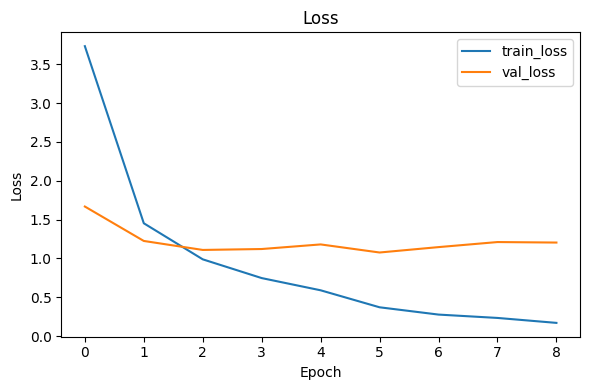

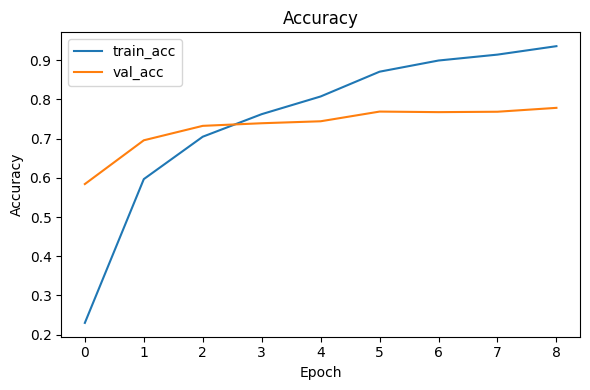

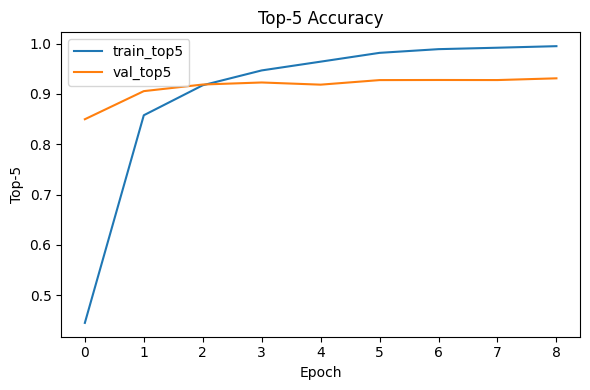

In [20]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(6,4))
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.tight_layout(); plt.show()

if 'top5' in hist.columns and 'val_top5' in hist.columns:
    plt.figure(figsize=(6,4))
    plt.plot(hist['top5'], label='train_top5')
    plt.plot(hist['val_top5'], label='val_top5')
    plt.legend(); plt.title('Top-5 Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Top-5'); plt.tight_layout(); plt.show()


## Evaluate on Test Set

In [21]:
y_proba = model.predict(X_test_seq, batch_size=cfg.batch_size)
y_pred = np.argmax(y_proba, axis=1)

acc = (y_pred == y_test).mean()
macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
bal_acc = balanced_accuracy_score(y_test, y_pred)
top5 = top_k_accuracy_score(y_test, y_proba, k=5, labels=list(range(num_classes)))

print({'accuracy': acc, 'macro_f1': macro_f1, 'balanced_accuracy': bal_acc, 'top5_accuracy': top5})

report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
with open(os.path.join(cfg.out_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)
print(report)


114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
{'accuracy': np.float64(0.7659194058588915), 'macro_f1': 0.7859618497495382, 'balanced_accuracy': np.float64(0.7886126393357692), 'top5_accuracy': np.float64(0.9272452207399258)}
                                                precision    recall  f1-score   support

                                  3-d graphics       0.85      0.79      0.82        29
                        adoption and fostering       0.96      0.80      0.87        30
                               adult education       0.75      0.71      0.73        34
                              adventure travel       0.67      0.67      0.67        27
                                 africa travel       0.76      0.87      0.81        30
                                   agriculture       0.64      0.74      0.69        31
                                    air travel       0.91      0.94      0.92        31
                           alcoholic beverages       0.79      0.79      0

## Confusion Matrix (Optional: Large)

In [22]:
do_confusion = False  # Set to True to plot the full matrix (432x432) which may be very large
if do_confusion:
    cm = confusion_matrix(y_test, y_pred, labels=list(range(num_classes)))
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, aspect='auto')
    plt.title('Confusion Matrix (truncated view)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    np.save(os.path.join(cfg.out_dir, 'confusion_matrix.npy'), cm)


## Save Model & Artifacts

In [23]:
stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f'/content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/cnn/cnn_model.keras'
model.save(model_path)
print('Saved model to:', model_path)

# Save label mapping
label_map = {int(i): cls for i, cls in enumerate(le.classes_)}
with open(os.path.join(cfg.out_dir, 'label_map.json'), 'w') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

# Save predictions
pred_df = pd.DataFrame({
    'text': X_test,
    'true_label': le.inverse_transform(y_test),
    'pred_label': le.inverse_transform(y_pred)
})
pred_path = os.path.join(cfg.out_dir, 'test_predictions.csv')
pred_df.to_csv(pred_path, index=False)
pred_df.head()


Saved model to: /content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/cnn/cnn_model.keras


,text,true_label,pred_label
0,Salt helps draw moisture to the surface early ...,barbecues and grilling,healthy cooking and eating
1,A project-based learning unit connected scienc...,education,education
2,The new urban EV demonstrates how auto technol...,auto technology,auto technology
3,stainless steel va powdercoated semigloss ral ...,birds,home appliances
4,home much vehicle market stabilizing many buye...,auto type,auto type


## Inference Helper

Saved per-class metrics to: artifacts_cnn/per_class_metrics_20251020_203227.csv
Saved: artifacts_cnn/top_misclass_pairs_20251020_203227.csv


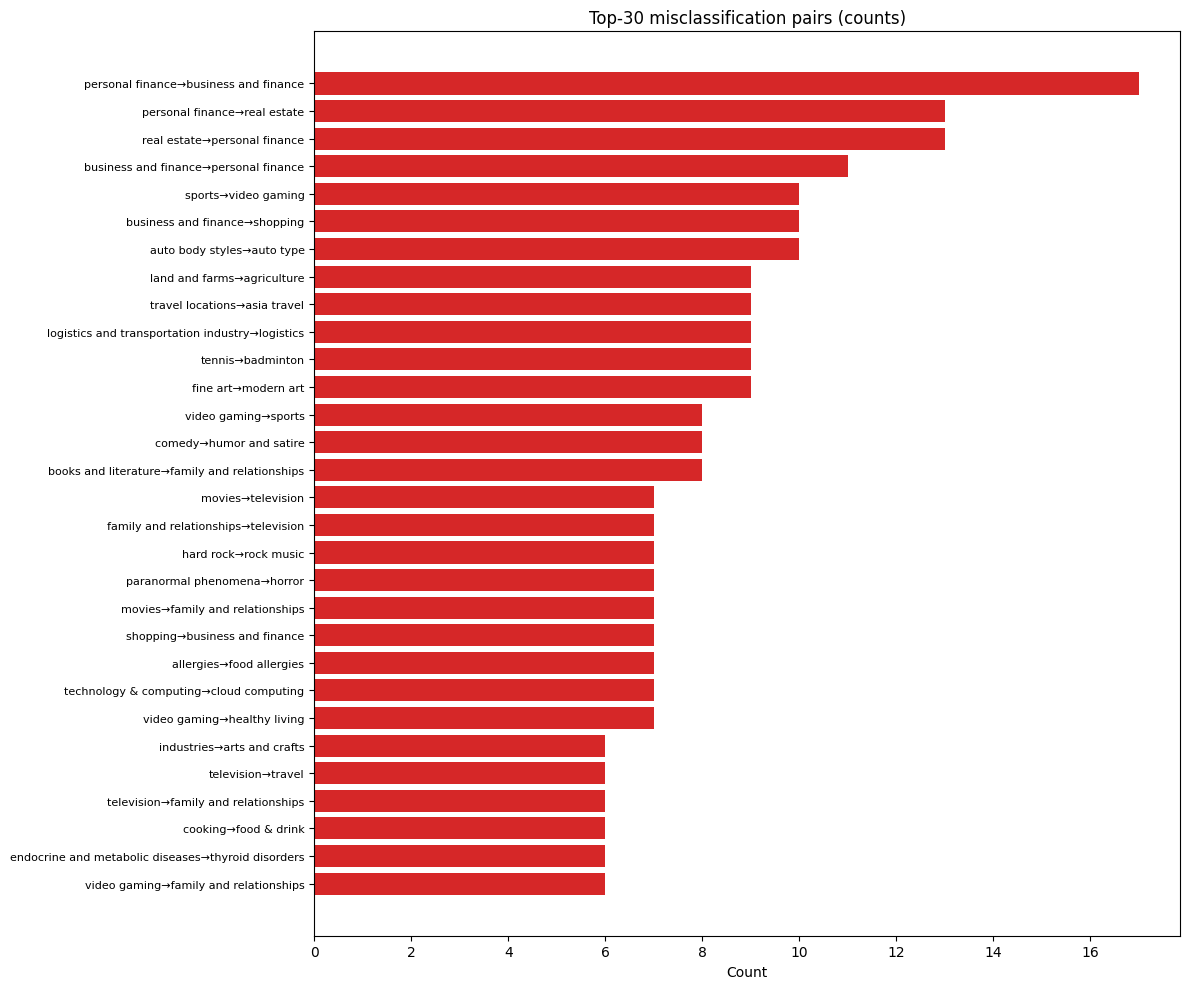

Saved per-class metrics to: artifacts_cnn/per_class_metrics_20251020_203227.csv


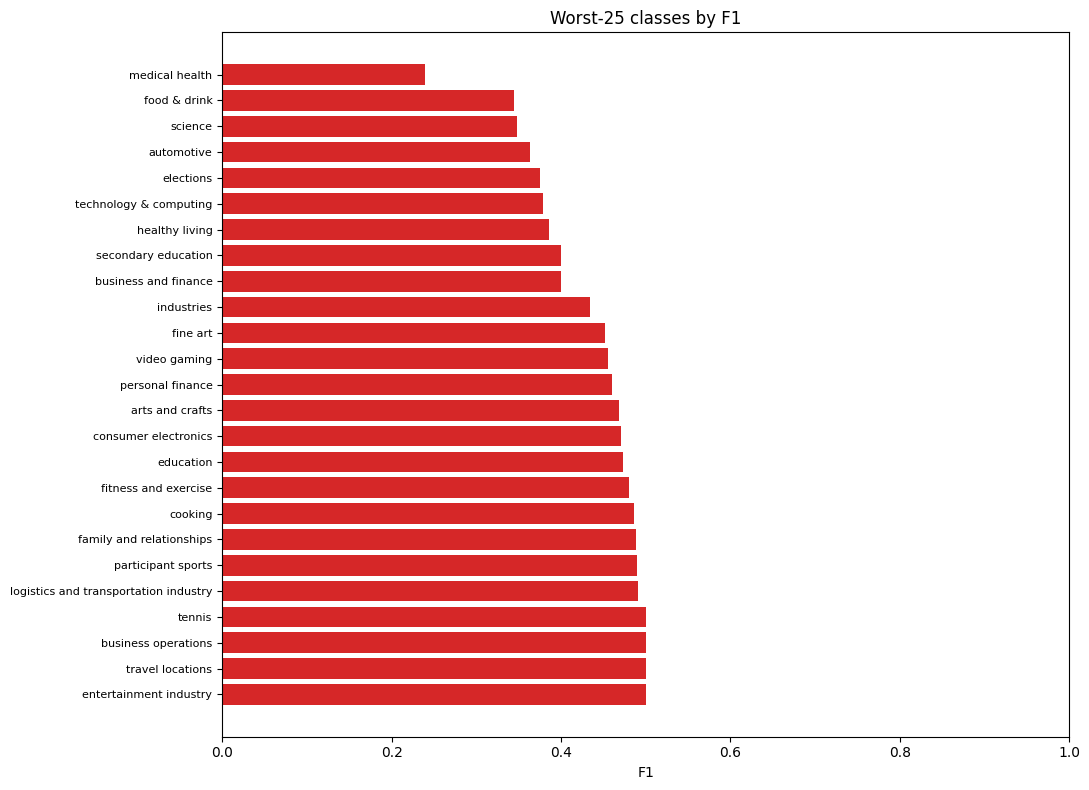

Saved: artifacts_cnn/per_class_f1_worst_25_20251020_203227.png


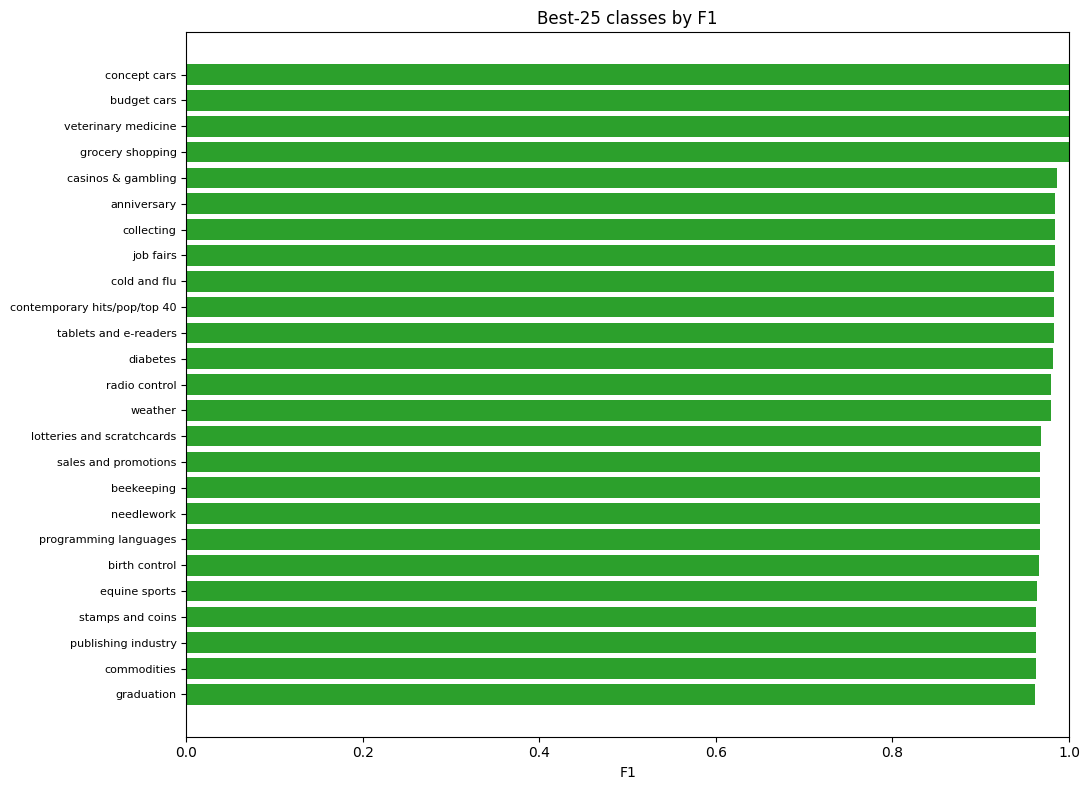

Saved: artifacts_cnn/per_class_f1_best_25_20251020_203227.png


In [24]:
# Stronger multi-branch Text-CNN (Kim-style) with label smoothing and top-5 metric
# The code in this cell was copied from another cell and some modifications were made.

# Per-class F1 sorted (worst 30 and best 30)

# Build per-class metrics dataframe using existing predictions and label encoder
cr_dict = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0,
    output_dict=True
)

rows = []
for cls in le.classes_:
    if cls in cr_dict:
        m = cr_dict[cls]
        rows.append({
            "class": cls,
            "precision": float(m.get("precision", 0.0)),
            "recall": float(m.get("recall", 0.0)),
            "f1": float(m.get("f1-score", 0.0)),
            "support": int(m.get("support", 0)),
        })

metrics_df = pd.DataFrame(rows).sort_values("f1", ascending=True).reset_index(drop=True)

# Export CSVs
# The stamp variable is defined later in the notebook, so it's not available here.
# Using _ts as defined later as well.
_ts = stamp if 'stamp' in globals() else datetime.now().strftime('%Y%m%d_%H%M%S')
metrics_path = os.path.join(cfg.out_dir, f"per_class_metrics_{_ts}.csv")
metrics_df.to_csv(metrics_path, index=False)
print("Saved per-class metrics to:", metrics_path)

# -------------------------
# 1) Top-N misclassification pairs
# -------------------------
# Labels are 0..num_classes-1 and map to le.classes_
classes_sorted = list(range(num_classes))

cm_counts = confusion_matrix(y_test, y_pred, labels=classes_sorted)
cm_no_diag = cm_counts.copy()
np.fill_diagonal(cm_no_diag, 0)

pairs = []
for i_true in range(num_classes):
    for j_pred in range(num_classes):
        cnt = cm_no_diag[i_true, j_pred]
        if cnt > 0:
            true_c = le.classes_[i_true]
            pred_c = le.classes_[j_pred]
            pairs.append((true_c, pred_c, int(cnt)))

pairs_df = pd.DataFrame(pairs, columns=["true_label", "pred_label", "count"]).sort_values("count", ascending=False).reset_index(drop=True)

TOP_N_PAIRS = 30
pairs_top = pairs_df.head(TOP_N_PAIRS).copy()

# Save CSV
# _ts defined above
pairs_path = os.path.join(cfg.out_dir, f"top_misclass_pairs_{_ts}.csv")
pairs_df.to_csv(pairs_path, index=False)
print("Saved:", pairs_path)

# Plot
plt.figure(figsize=(12, 10))
labels_bar = [f"{t}→{p}" for t, p, _ in pairs_top[["true_label", "pred_label", "count"]].values]
y_pos = np.arange(len(pairs_top))
plt.barh(y_pos, pairs_top["count"].values, color="#d62728")
plt.yticks(y_pos, labels_bar, fontsize=8)
plt.gca().invert_yaxis()
plt.title(f"Top-{TOP_N_PAIRS} misclassification pairs (counts)")
plt.xlabel("Count")
# Annotate counts
# for i, c in enumerate(pairs_top["count"].values):
    # plt.text(c + 0.5, i, str(c), va="center", fontsize=8)
plt.tight_layout()
plt.show()

# -------------------------
# Per-class F1 sorted (worst 30 and best 30)
# -------------------------

# Build per-class metrics dataframe using existing predictions and label encoder
cr_dict = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0,
    output_dict=True
)

rows = []
for cls in le.classes_:
    if cls in cr_dict:
        m = cr_dict[cls]
        rows.append({
            "class": cls,
            "precision": float(m.get("precision", 0.0)),
            "recall": float(m.get("recall", 0.0)),
            "f1": float(m.get("f1-score", 0.0)),
            "support": int(m.get("support", 0)),
        })

metrics_df = pd.DataFrame(rows).sort_values("f1", ascending=True).reset_index(drop=True)

# Save full per-class metrics
# stamp variable is defined later in the notebook, so it's not available here.
metrics_path = os.path.join(cfg.out_dir, f"per_class_metrics_{_ts}.csv")
metrics_df.to_csv(metrics_path, index=False)
print("Saved per-class metrics to:", metrics_path)

# Plot worst-K and best-K by F1
K = 25
worst_k = metrics_df.head(K)
best_k = metrics_df.tail(K).sort_values("f1", ascending=False)

# Worst-K
fig = plt.figure(figsize=(11, 8))
plt.barh(np.arange(len(worst_k)), worst_k["f1"].values, color="#d62728")
plt.yticks(np.arange(len(worst_k)), worst_k["class"].values, fontsize=8)
plt.gca().invert_yaxis()
plt.title(f"Worst-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
out_path_worst = os.path.join(cfg.out_dir, f"per_class_f1_worst_{K}_{_ts}.png")
fig.savefig(out_path_worst, dpi=150)
plt.show()
print("Saved:", out_path_worst)

# Best-K
fig = plt.figure(figsize=(11, 8))
plt.barh(np.arange(len(best_k)), best_k["f1"].values, color="#2ca02c")
plt.yticks(np.arange(len(best_k)), best_k["class"].values, fontsize=8)
plt.gca().invert_yaxis()
plt.title(f"Best-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
out_path_best = os.path.join(cfg.out_dir, f"per_class_f1_best_{K}_{_ts}.png")
fig.savefig(out_path_best, dpi=150)
plt.show()
print("Saved:", out_path_best)

Saved per-class metrics to: artifacts_cnn/per_class_metrics_20251020_203227.csv


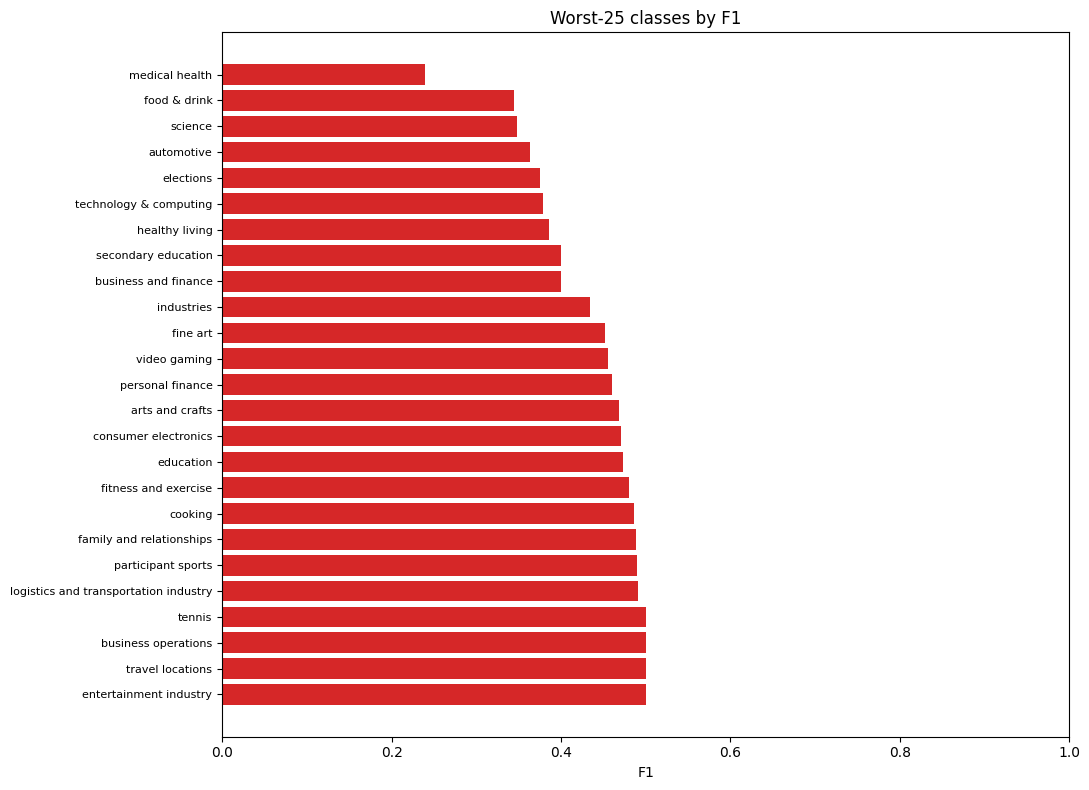

Saved: artifacts_cnn/per_class_f1_worst_25_20251020_203227.png


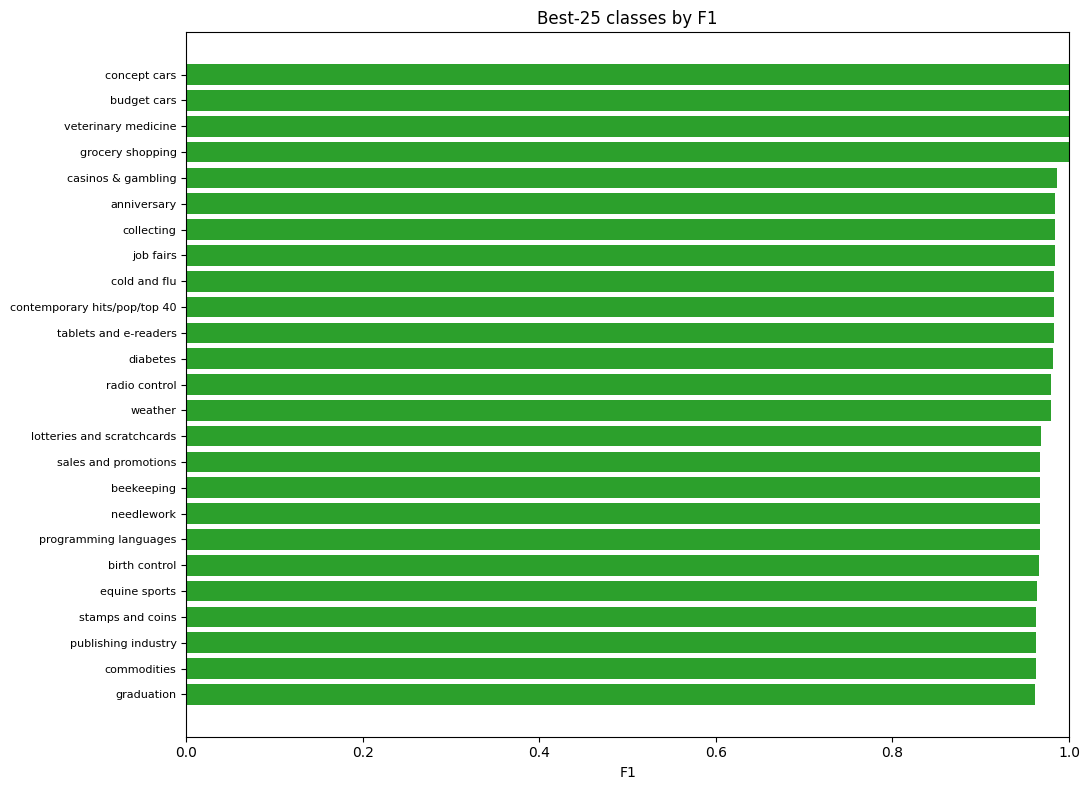

Saved: artifacts_cnn/per_class_f1_best_25_20251020_203227.png


In [25]:
# Per-class F1 sorted (worst 30 and best 30)

# Build per-class metrics dataframe using existing predictions and label encoder
cr_dict = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0,
    output_dict=True
)

rows = []
for cls in le.classes_:
    if cls in cr_dict:
        m = cr_dict[cls]
        rows.append({
            "class": cls,
            "precision": float(m.get("precision", 0.0)),
            "recall": float(m.get("recall", 0.0)),
            "f1": float(m.get("f1-score", 0.0)),
            "support": int(m.get("support", 0)),
        })

metrics_df = pd.DataFrame(rows).sort_values("f1", ascending=True).reset_index(drop=True)

# Save full per-class metrics
metrics_path = os.path.join(cfg.out_dir, f"per_class_metrics_{stamp}.csv") if 'stamp' in globals() else os.path.join(cfg.out_dir, "per_class_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("Saved per-class metrics to:", metrics_path)

# Plot worst-K and best-K by F1
K = 25
worst_k = metrics_df.head(K)
best_k = metrics_df.tail(K).sort_values("f1", ascending=False)

# Worst-K
fig = plt.figure(figsize=(11, 8))
plt.barh(np.arange(len(worst_k)), worst_k["f1"].values, color="#d62728")
plt.yticks(np.arange(len(worst_k)), worst_k["class"].values, fontsize=8)
plt.gca().invert_yaxis()
plt.title(f"Worst-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
out_path_worst = os.path.join(cfg.out_dir, f"per_class_f1_worst_{K}_{stamp}.png") if 'stamp' in globals() else os.path.join(cfg.out_dir, f"per_class_f1_worst_{K}.png")
fig.savefig(out_path_worst, dpi=150)
plt.show()
print("Saved:", out_path_worst)

# Best-K
fig = plt.figure(figsize=(11, 8))
plt.barh(np.arange(len(best_k)), best_k["f1"].values, color="#2ca02c")
plt.yticks(np.arange(len(best_k)), best_k["class"].values, fontsize=8)
plt.gca().invert_yaxis()
plt.title(f"Best-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
out_path_best = os.path.join(cfg.out_dir, f"per_class_f1_best_{K}_{stamp}.png") if 'stamp' in globals() else os.path.join(cfg.out_dir, f"per_class_f1_best_{K}.png")
fig.savefig(out_path_best, dpi=150)
plt.show()
print("Saved:", out_path_best)

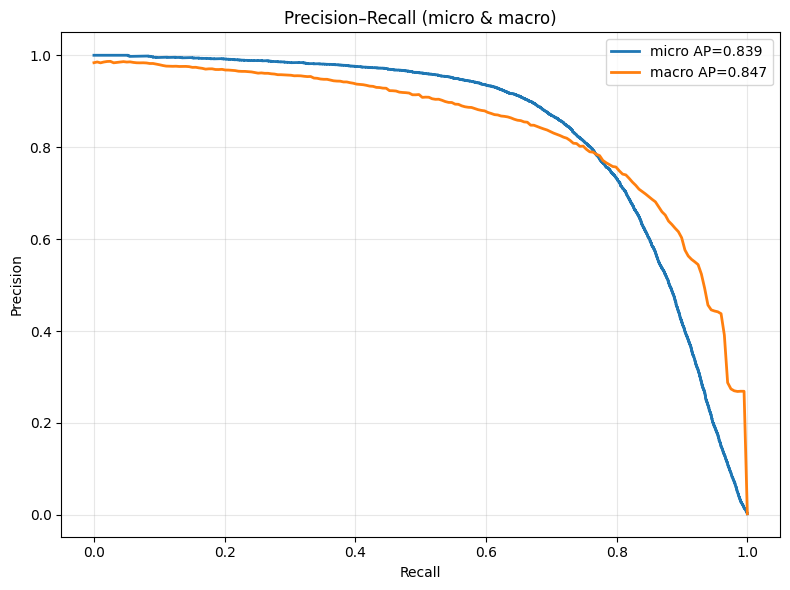

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# -------------------------
# Precision–Recall (micro & macro)
# -------------------------

# y_test is already encoded (0..num_classes-1), y_proba already computed
Y = label_binarize(y_test, classes=np.arange(num_classes))

# Micro-average
prec_micro, rec_micro, _ = precision_recall_curve(Y.ravel(), y_proba.ravel())
ap_micro = average_precision_score(Y, y_proba, average="micro")

# Macro-average
precisions = []
recalls = []
ap_list = []
for i in range(num_classes):
    p_i, r_i, _ = precision_recall_curve(Y[:, i], y_proba[:, i])
    recalls.append(r_i[::-1])
    precisions.append(p_i[::-1])
    ap_list.append(average_precision_score(Y[:, i], y_proba[:, i]))

grid = np.linspace(0, 1, 200)
prec_interp = []
for r, p in zip(recalls, precisions):
    prec_interp.append(np.interp(grid, r, p, left=p[0], right=p[-1]))
prec_macro = np.mean(np.vstack(prec_interp), axis=0)
rec_macro = grid
ap_macro = float(np.mean(ap_list))

# Plot
fig = plt.figure(figsize=(8, 6))
plt.plot(rec_micro, prec_micro, label=f"micro AP={ap_micro:.3f}", linewidth=2)
plt.plot(rec_macro, prec_macro, label=f"macro AP={ap_macro:.3f}", linewidth=2)
plt.title("Precision–Recall (micro & macro)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.out_dir, f'precision_recall_{stamp}.png'), dpi=150)
plt.show()

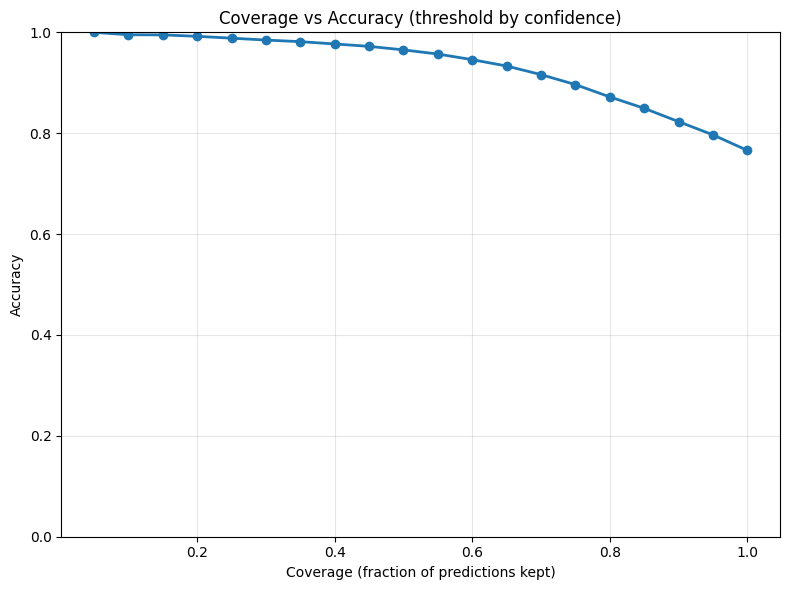

In [27]:
# -------------------------
# Coverage vs Accuracy curve
# -------------------------
# Sort predictions by max probability; show accuracy at different coverage levels
max_prob = y_proba.max(axis=1)
correct = (y_pred == y_test)
order = np.argsort(-max_prob)
sorted_correct = correct[order]

covers = np.linspace(0.05, 1.0, 20)
acc_at_cov = []
n = len(sorted_correct)
for c in covers:
    k = int(np.ceil(c * n))
    acc_at_cov.append(sorted_correct[:k].mean())

fig = plt.figure(figsize=(8, 6))
plt.plot(covers, acc_at_cov, marker='o', linewidth=2, markersize=6)
plt.title('Coverage vs Accuracy (threshold by confidence)')
plt.xlabel('Coverage (fraction of predictions kept)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.out_dir, f'coverage_accuracy_{stamp}.png'), dpi=150)
plt.show()

In [28]:
proba = model.predict(X_test_seq, batch_size=512, verbose=0)
y_pred = proba.argmax(axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1_mac = f1_score(y_test, y_pred, average="macro")
top5 = top_k_accuracy_score(y_test, proba, k=5, labels=np.arange(num_classes))

print(f"Test metrics:\n"
      f"- Accuracy:           {acc:.4f}\n"
      f"- Balanced accuracy:  {bal_acc:.4f}\n"
      f"- F1 (macro):         {f1_mac:.4f}\n"
      f"- Top-5 accuracy:     {top5:.4f}")


Test metrics:
- Accuracy:           0.7659
- Balanced accuracy:  0.7886
- F1 (macro):         0.7860
- Top-5 accuracy:     0.9272


## Notes
- Adjust `vocab_size`, `max_len`, and model widths to fit your dataset scale.
- For long texts, consider larger `max_len` or hierarchical/Transformer models.
- To replicate the exact plots from the XGBoost notebook, reuse the plotting code around the produced `history.csv` and `test_predictions.csv`.
- If you want to freeze the `Embedding` early, set `trainable=False` initially and unfreeze later.
